#Introduction
This is the project directed to the study in NLP field. The result of this work is the small model for translation words from RU to ENG and wiseverse. The project easyly can be extented to more complex translation model by extending dataset and adding new languages.

The project is created in the process of studing basics of NN specially NLP models. The source of the content is the study course of N.E. Bauman Moscow State Technical University:

Sourse: [Youtube](https://www.youtube.com/playlist?list=PLgtntV-BLRqgJRhcZHz8GtFC3j_F27IDg)

Code: [GitHub](https://github.com/averkij/mstu-nlp-course)

#Setting up the env

In [1]:
!nvidia-smi

Thu Oct 10 09:38:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P0             16W /   75W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

It is important to have nvidia gpu in your execution environment and drivers to it installed because the model is running from cuda!!

In [2]:
!pip install transformers sentencepiece datasets translate-toolkit --quiet
!pip install torch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
from torch import optim
from torch.nn import functional as F

with io.capture_output() as captured:
  !pip install transformers sentencepiece

from transformers import AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

from transformers.models.mt5 import MT5Config, MT5ForConditionalGeneration

sns.set()

#Preparing data

OPUS (https://opus.nlpl.eu/)

![](https://www.sketchengine.eu/wp-content/uploads/opus_comparison_chart.png)

Here the code for getting the data from internet. Works with colab.

In [1]:
!wget https://object.pouta.csc.fi/OPUS-Tatoeba/v2021-07-22/tmx/en-ru.tmx.gz

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [2]:
!gzip -d en-ru.tmx.gz

"gzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


The preparation of data

In [4]:
with open("content/en-ru.tmx", 'r', encoding="utf-8") as input_file:
  for x in range(50):
    print(input_file.readline())

<?xml version="1.0" encoding="UTF-8" ?>

<tmx version="1.4">

<header creationdate="Thu Jul 22 19:16:34 2021"

          srclang="en"

          adminlang="en"

          o-tmf="unknown"

          segtype="sentence"

          creationtool="Uplug"

          creationtoolversion="unknown"

          datatype="PlainText" />

  <body>

    <tu>

      <tuv xml:lang="en"><seg>For once in my life I'm doing a good deed... And it is useless. </seg></tuv>

      <tuv xml:lang="ru"><seg>Один раз в жизни я делаю хорошее дело... И оно бесполезно. </seg></tuv>

    </tu>

    <tu>

      <tuv xml:lang="en"><seg>Let's try something. </seg></tuv>

      <tuv xml:lang="ru"><seg>Давайте что-нибудь попробуем! </seg></tuv>

    </tu>

    <tu>

      <tuv xml:lang="en"><seg>Let's try something. </seg></tuv>

      <tuv xml:lang="ru"><seg>Давайте что-нибудь попробуем. </seg></tuv>

    </tu>

    <tu>

      <tuv xml:lang="en"><seg>I have to go to sleep. </seg></tuv>

      <tuv xml:lang="ru"><seg>Мне п

In [15]:
!pip install translate-toolkit

In [5]:
from translate.storage.tmx import tmxfile

with open("content/en-ru.tmx", 'rb') as input_file:
  tmx_file = tmxfile(input_file, 'en', 'ru')

In [6]:
dataset = []

for node in tmx_file.unit_iter():
  dataset.append({'en': node.source, 'ru': node.target})

In [7]:
len(dataset)

523629

#Split dataset
100.000 elements for training and 5.000 for tests.

In [8]:
train_dataset = dataset[:100000]
test_dataset = dataset[100000:105000]

#Examples of elements

In [9]:
import random

for i in range(10):
  k = random.randint(0, 100000)
  print(dataset[k])

{'en': 'I pledged my loyalty to him. ', 'ru': 'Я заверил его в своей преданности. '}
{'en': 'You had better not go there again. ', 'ru': 'Ты бы лучше не ходил снова туда. '}
{'en': 'I feel like eating something sweet. ', 'ru': 'Мне хочется чего-нибудь сладкого. '}
{'en': 'Wages vary in relation to the age of the worker. ', 'ru': 'Заработок варьируется в зависимости от возраста работника. '}
{'en': 'I play tennis every day. ', 'ru': 'Я играю в теннис каждый день. '}
{'en': "The lake has frozen over but I'm not sure the ice is strong enough to walk on. ", 'ru': 'Озеро замёрзло, но я не уверен, что лёд достаточно прочный, чтобы по нему ходить. '}
{'en': "It won't hurt. ", 'ru': 'Болеть не будет. '}
{'en': 'I like you a lot. ', 'ru': 'Ты мне очень нравишься. '}
{'en': 'Maybe he will be a good teacher. ', 'ru': 'Может быть, он будет хорошим учителем. '}
{'en': 'When are you going home? ', 'ru': 'Когда идёшь домой? '}


#Preparing model

**Using open sourse model:**

Sourse: [A Massively Multilingual Pre-trained Text-to-Text Transformer](https://www.google.com/url?q=https%3A%2F%2Faclanthology.org%2F2021.naacl-main.41%2F)

Code: [GitHub](https://github.com/google-research/multilingual-t5)

In [10]:
model_repo = 'google/mt5-base'

config = MT5Config.from_pretrained(model_repo)

In [11]:
config.max_length

20

In [12]:
max_seq_len = config.max_length

In [13]:
!pip install sentencepiece
!pip install protobuf

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
C:\Users\Admin\Desktop\Питон\fine\.venv\lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [15]:
print(torch.cuda.is_available())

True


In [20]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [16]:
model = MT5ForConditionalGeneration.from_pretrained(model_repo)
model = model.cuda()

#Adding special tokens

In [17]:
LANG_TOKEN_MAPPING = {
    'ru': '<ru>',
    'en': '<en>'
}

In [18]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 768)

In [19]:
example_input_str = '<ru>Давайте токенизируем это предложение.'
input_ids = tokenizer.encode(example_input_str,
                             return_tensors='pt',
                             padding='max_length',
                             truncation=True,
                             max_length=max_seq_len)
print(input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)

tensor([[250100,   3348,  36456,   1049,   1625,  42547,  76660,   1436,  44616,
            324,    260,      1,      0,      0,      0,      0,      0,      0,
              0,      0]])
['<ru>', '▁Да', 'вайте', '▁то', 'ке', 'низ', 'ируем', '▁это', '▁предложени', 'е', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [20]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(input_text, target_lang, tokenizer, seq_len, lang_token_map)
  target_token_ids = encode_target_str(target_text, tokenizer, seq_len)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch:
    formatted_data = format_translation_data(translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data(dataset, lang_token_map, tokenizer, batch_size=32):
  np.random.shuffle(dataset)
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]

    yield transform_batch(raw_batch, lang_token_map, tokenizer)

#Load pretrained

In [21]:
model_path = 'content/mt5_translation_example.pt'
model_path_last = 'content/mt5_translation_example_last.pt'

#Train

In [22]:
n_epochs = 5
batch_size = 20
print_freq = 100

lr = 5e-4

checkpoint_freq = 1000

n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

print("n_batches", n_batches)
print("total_steps", total_steps)
print("n_warmup_steps", n_warmup_steps)

n_batches 5000
total_steps 25000
n_warmup_steps 250


In [23]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

losses = []
test_losses = []

C:\Users\Admin\Desktop\Питон\fine\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def eval_model(model, dataset, max_iters=8):
  test_generator = get_data(dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  with torch.no_grad():
    for i, (input_batch, label_batch) in enumerate(test_generator):
      if i >= max_iters:
        break

      model_out = model.forward(
          input_ids = input_batch,
          labels = label_batch)
      eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [25]:
best_test_loss = float('inf')

In [26]:
for epoch_idx in range(n_epochs):
  data_generator = get_data(train_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) in tqdm(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    loss = model_out.loss
    losses.append(loss.item())

    loss.backward()

    optimizer.step()
    scheduler.step()

      # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {:.6f}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      test_losses.append(test_loss)
      print('Test loss {:.3f}'.format(test_loss))
      if best_test_loss > test_loss:
        print('Saving model with test loss of {:.3f}'.format(test_loss))
        torch.save(model.state_dict(), model_path)
        best_test_loss = test_loss

  torch.save(model.state_dict(), model_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

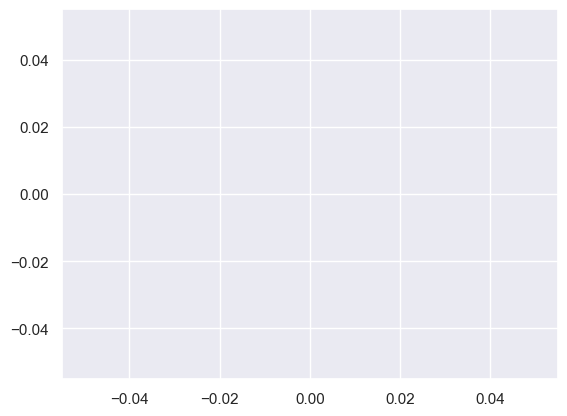

In [27]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [28]:
torch.save(model.state_dict(), model_path_last)

RuntimeError: File /mt5_translation_example_last.pt cannot be opened.

#Test

In [29]:
test_sentence = test_dataset[16]['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ru',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)

input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: There is no anwser for your question. 
Truncated input text: <ru> There is no anwser for your question.</s><pad><pad><pad><pad><pad><pad><pad>


In [30]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)

for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

C:\Users\Admin\Desktop\Питон\fine\.venv\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<extra_id_0> for a question
<extra_id_0>. .
<extra_id_0>. You are here


In [31]:
def translate(text, lang_from, lang_to):

  input_ids = encode_input_str(
      text = text,
      target_lang = lang_to,
      tokenizer = tokenizer,
      seq_len = model.config.max_length,
      lang_token_map = LANG_TOKEN_MAPPING)

  input_ids = input_ids.unsqueeze(0).cuda()

  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1)

  res = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

  return res

def translate_to_english(text):
  return translate(text, 'ru', 'en')

def translate_to_russian(text):
  return translate(text, 'en', 'ru')


In [32]:
translate_to_english('Лондон — столица Великобритании')

'<extra_id_0> Лондон'